# Loading modules

In [12]:
import csv
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt




# Loading the data 

In [21]:

dataPath = "/Users/inclusive/creativeEnergy-/LabFit/training_data_dc.csv"
data = pd.read_csv(dataPath)

# rename specific cols 
data.rename(columns={"LPM Rota":"LPM_Rota", 'cd':'dcoef'}, inplace=True)
data0=data.drop(columns={'periph_ch1', 'periph_ch1_lpm',})
print(data0.columns)
		
# labFit CONSTANTs
A=0.21334
B=0.14933
C=0.033616
D=0.023546

# standard constants
output_lpm=100000  # atm pressure in Pa
Tsb=30.66         # 
c=273.15          # Kelvin temp correction 

# epsilon
epsilon=1e-1

Index(['Static Pressure', 'LPM_Rota', 'temp_mcu', 'Static_Pa', 'SP_mV',
       'DP_mV', 'Differential_Pa', 'Flow_lph', 'SB lpm', 'Accuracy', 'Error',
       'ideal flow', 'dcoef'],
      dtype='object')


# Meta-functions for computations 

In [22]:
# NB choice of best model is not based on accuracy is also based on functional form and possible runins resulting from 
# bad functional form 
# X1 : 'Static_Pa'  X2: 'Differential_Pa'
#data['labfit'] = data.apply(labfit_model, axis=1)
#data['labfit0'] = data.apply(lambda row: labfit_function(row), axis=1)
# labfit_best1 : Y=A/X2+B*EXP(C*X1)+D/X2**2 
# labfit_best0 : Y=A*X1**(B*X2**C)+D/X2

labfit1 = lambda row: A*row.Differential_Pa + B*np.exp(C*row.Static_Pa) + D/row.Differential_Pa**2 
labfit0 = lambda row: A*row.Differential_Pa**(B*row.Static_Pa**C) + D/row.Static_Pa


labfit1_scaled = lambda row: A*row.DP_scale + B*np.exp(C*row.SP_scale) + D/(row.DP_scale**2 + epsilon)
labfit0_scaled = lambda row: A*row.DP_scale**(B*row.SP_scale**C) + D/(row.SP_scale + epsilon)


LPM_rota_normalization = lambda row: row.LPM_Rota *( row.Static_Pa + output_lpm)/ output_lpm*(Tsb/(row.temp_mcu + c))
SB_lpm = lambda row: row.Flow_lph/60 



# Computing desired variables to from system
# reference readings and in house readings 

In [16]:
# unscaled 
data0['labfit_dcoef0'] = data0.apply(labfit0, axis=1)
data0['labfit_dcoef1'] = data0.apply(labfit1, axis=1)


#  
data0['LPM_rota_norm'] = data0.apply(LPM_rota_normalization, axis=1)
data0['SB_lpm'] = data0.apply(SB_lpm, axis=1)
data0['dcoef0'] = data0['LPM_rota_norm']/data0['SB_lpm']


# Min-Max scaling  
data0['SP_scale'] =  (data0.Static_Pa - min(data0.Static_Pa))/ (max(data0.Static_Pa) - min(data0.Static_Pa) ) 
data0['DP_scale'] =  (data0.Differential_Pa - min(data0.Differential_Pa))/ (max(data0.Differential_Pa) - min(data0.Differential_Pa)) 


# scaled results
data0['dc_lfs0'] = data0.apply(labfit0_scaled, axis=1)
data0['dc_lfs1'] = data0.apply(labfit1_scaled, axis=1)


/var/folders/zm/fyjdg5p14hvcdsrc_bypfmym0000gp/T/ipykernel_15333/899616055.py:9: RuntimeWarning: overflow encountered in exp
  labfit1 = lambda row: A*row.Differential_Pa + B*np.exp(C*row.Static_Pa) + D/row.Differential_Pa**2


In [17]:
data0.columns

Index(['Static Pressure', 'LPM_Rota', 'temp_mcu', 'Static_Pa', 'SP_mV',
       'DP_mV', 'Differential_Pa', 'Flow_lph', 'SB lpm', 'Accuracy', 'Error',
       'ideal flow', 'dcoef', 'labfit_dcoef0', 'labfit_dcoef1',
       'LPM_rota_norm', 'SB_lpm', 'dcoef0', 'SP_scale', 'DP_scale', 'dc_lfs0',
       'dc_lfs1'],
      dtype='object')

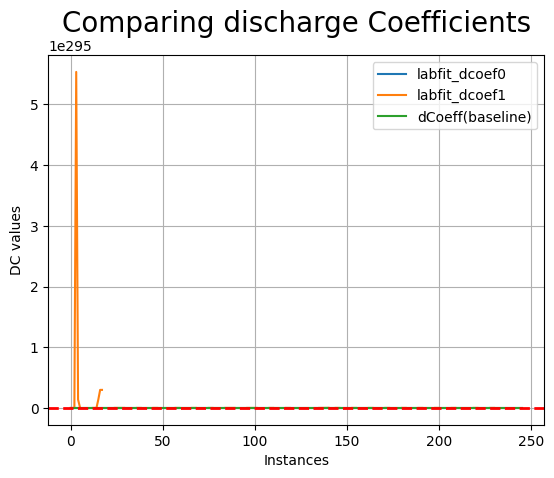

In [20]:
plt.plot(data0['labfit_dcoef0'], label='labfit_dcoef0')
plt.plot(data0['labfit_dcoef1'], label='labfit_dcoef1')
plt.plot(data0['dcoef0'], label='dCoeff(baseline)')
plt.axhline(y=1, linestyle='--', color='red', linewidth=2.0)
plt.title('Comparing discharge Coefficients', fontsize=20)
plt.xlabel('Instances', fontsize=10)
plt.ylabel('DC values', fontsize=10)
plt.grid(True)
plt.legend()
#plt.plot(data['labfit0']/data['Static_Pa'])

In [ ]:
# the graph data... 
# 

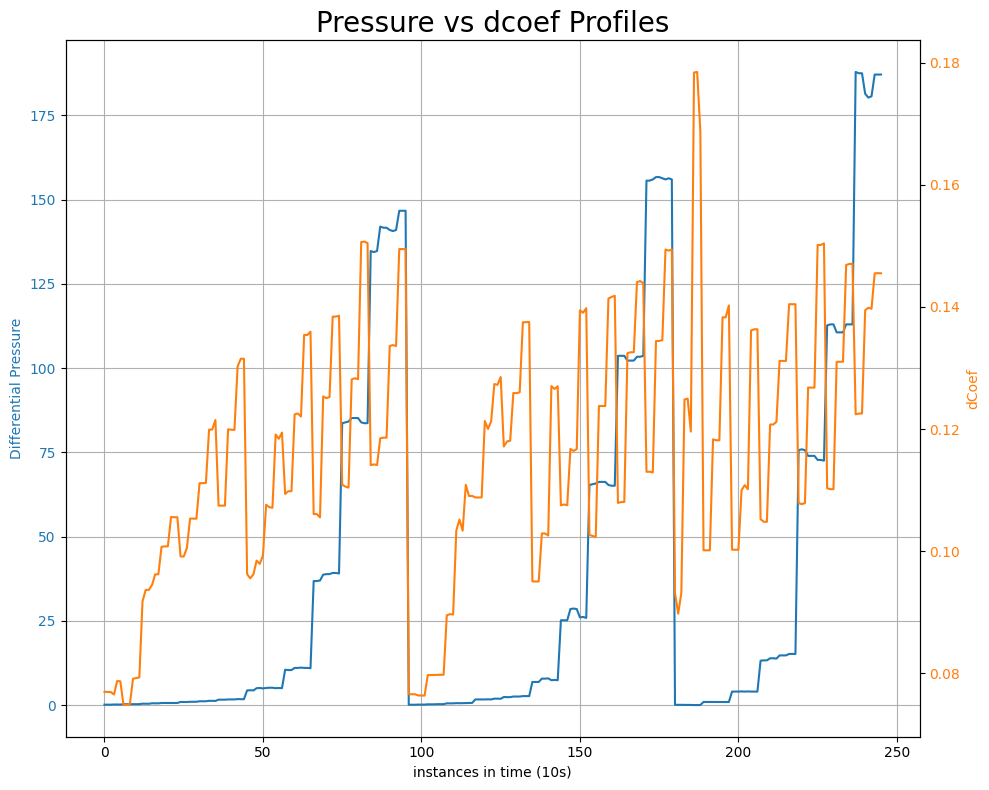

In [32]:
# I want to see the dcoef against the pressure/statics and differential 

#plt.plot(data0['Static_Pa'], label='Static Pressure')
#plt.plot(data0['dcoef0'], label='dCoef (baseline)')


fig, ax1 = plt.subplots(figsize=(10, 8))

color = 'tab:blue'
ax1.set_xlabel('instances in time (10s)', fontsize=10)
ax1.set_ylabel('Differential Pressure', color=color, fontsize=10)
ax1.plot(data0['Differential_Pa'], label='Differential Pressure', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('dCoef', color=color, fontsize=10)  # we already handled the x-label with ax1
ax2.plot(data0['dcoef0'], label='dCoef (baseline)', color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Differential Pressure vs dcoef Profiles', fontsize=20)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [ ]:
# give meaning to time axis to see 
# mark peaks 
# normalise static presssure (z-score)
# consider z-scoring the variables
# rescale the variables to lie between (0, 1) -- rescaled the variables... 
# 

In [111]:
spdcoef_corr_scaled = np.corrcoef(data0['SP_scale'], data0['dcoef0'])
dpdcoef_corr_scaled = np.corrcoef(data0['DP_scale'], data0['dcoef0'])

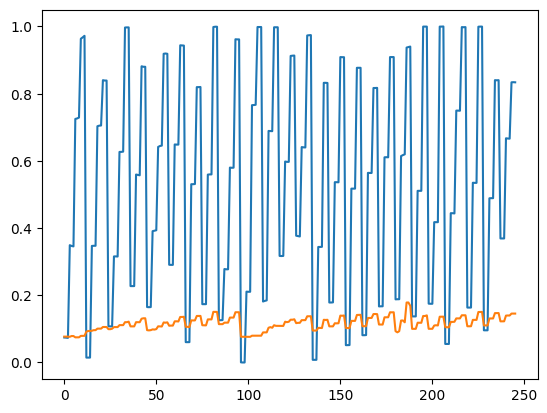

In [109]:
plt.plot(SP_scale)
plt.plot(data0['dcoef0'])

In [ ]:
np.corrcoef(SP_scale, data )

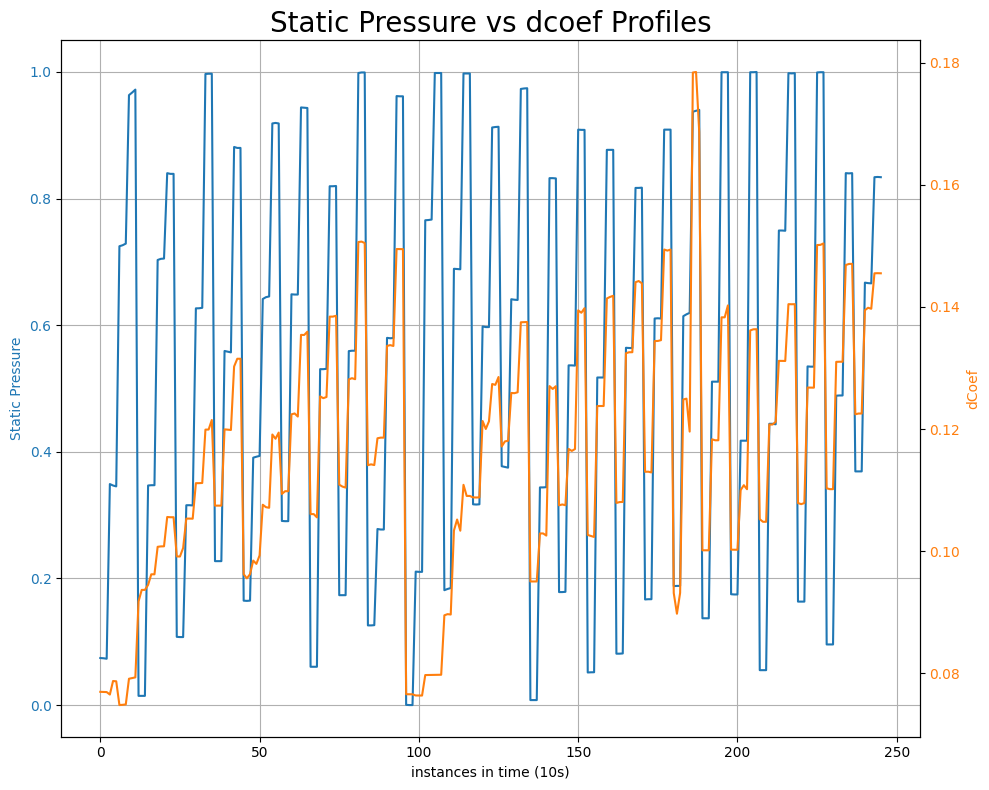

In [106]:
fig, ax1 = plt.subplots(figsize=(10, 8))

color = 'tab:blue'
ax1.set_xlabel('instances in time (10s)', fontsize=10)
ax1.set_ylabel('Static Pressure', color=color, fontsize=10)
ax1.plot(data0['SP_scale'], label='Static Pressure', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('dCoef', color=color, fontsize=10)  # we already handled the x-label with ax1
ax2.plot(data0['dcoef0'], label='dCoef (baseline)', color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Static Pressure vs dcoef Profiles', fontsize=20)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [ ]:
# where is the static pressure reading from?
# the baseline dCoeff closely follows the static pressure...
# its more sensitive to the static pressure than differential pressure 
# the flow meters are more sensitive to static pressure than to differential pressure
# is this surprising? (we do some conversions of the readings from the meter before the computations)
# in the excel is says new cd (static pressure)
# why does static pressure fluctuate a lot? 
# it is unlikely its manually controlled ( given the resolution of the fluctuations)? 
# why use the static pressure and differential pressure (these are the raw values from the meter)


In [36]:
np.corrcoef(data0['Differential_Pa'], data0['dcoef0']) 

array([[1.       , 0.4512055],
       [0.4512055, 1.       ]])

In [37]:
np.corrcoef(data0['LPM_rota_norm'], data0['dcoef0']) 

array([[1.        , 0.57327973],
       [0.57327973, 1.        ]])

In [78]:
# structuring a model 
# static pressure, differential pressure, decof0

# surrogate data 
x0=np.random.rand(100,)
x1=np.random.rand(100,)
y = x0 + x1 
X=np.vstack((x0, x1)).reshape(-1, 2)

In [71]:
x1.shape

(100,)

In [79]:
X.shape

(100, 2)

In [88]:
x1

array([0.72386447, 0.15773171, 0.6377968 , 0.25432274, 0.14902458,
       0.49753218, 0.50729614, 0.90065363, 0.5295597 , 0.2217575 ,
       0.36296267, 0.47735485, 0.86876114, 0.79548481, 0.58199079,
       0.09891882, 0.81971946, 0.32152288, 0.61283867, 0.34981789,
       0.2252848 , 0.89424704, 0.50838266, 0.86429215, 0.2491154 ,
       0.68571114, 0.23971143, 0.41737699, 0.01644695, 0.27552989,
       0.11851933, 0.63753742, 0.28591517, 0.68756607, 0.88619227,
       0.86273145, 0.30972222, 0.83593532, 0.92153105, 0.953047  ,
       0.81804562, 0.22576573, 0.13530402, 0.4967252 , 0.42893374,
       0.94336821, 0.6206201 , 0.72729028, 0.15824223, 0.23908143,
       0.6428688 , 0.40498955, 0.69881773, 0.99577537, 0.2229262 ,
       0.41643899, 0.56236304, 0.04211798, 0.60686442, 0.38244066,
       0.58107697, 0.68254819, 0.27549078, 0.86792563, 0.69573886,
       0.06744003, 0.52520716, 0.0124121 , 0.57323704, 0.233123  ,
       0.84877416, 0.00388119, 0.08589153, 0.52981614, 0.38629

In [87]:
x0

array([0.92370528, 0.57384075, 0.2268499 , 0.59000615, 0.23835545,
       0.40898177, 0.70110969, 0.70500228, 0.21308783, 0.97095643,
       0.31086077, 0.58175892, 0.2483866 , 0.91917177, 0.36907845,
       0.34358512, 0.98654699, 0.17450938, 0.25491894, 0.70636096,
       0.95118189, 0.45529399, 0.19135126, 0.53767672, 0.53073718,
       0.10534831, 0.09143452, 0.17369867, 0.1346386 , 0.93619627,
       0.91252163, 0.96545441, 0.66499302, 0.16961146, 0.20561614,
       0.1607193 , 0.45971159, 0.65247976, 0.86986818, 0.19458268,
       0.4307964 , 0.12849816, 0.74415832, 0.74775546, 0.6234157 ,
       0.11639228, 0.15912967, 0.11272138, 0.10198765, 0.75962922,
       0.04352149, 0.94366408, 0.44081759, 0.20082435, 0.47661041,
       0.51216201, 0.56901557, 0.06468532, 0.0273365 , 0.55523285,
       0.5537726 , 0.99658105, 0.52534592, 0.957188  , 0.2036983 ,
       0.87206292, 0.43652926, 0.62424083, 0.07246197, 0.49760646,
       0.36686224, 0.82358692, 0.79897704, 0.41153142, 0.35965

In [89]:
0.72386447 + 0.92370528

1.64756975

In [86]:
y

array([1.64756974, 0.73157246, 0.8646467 , 0.84432889, 0.38738003,
       0.90651394, 1.20840583, 1.60565591, 0.74264753, 1.19271393,
       0.67382343, 1.05911377, 1.11714775, 1.71465658, 0.95106924,
       0.44250394, 1.80626644, 0.49603226, 0.86775761, 1.05617885,
       1.17646669, 1.34954103, 0.69973392, 1.40196887, 0.77985258,
       0.79105945, 0.33114595, 0.59107566, 0.15108555, 1.21172616,
       1.03104096, 1.60299182, 0.95090819, 0.85717752, 1.09180841,
       1.02345075, 0.76943381, 1.48841507, 1.79139923, 1.14762968,
       1.24884202, 0.3542639 , 0.87946234, 1.24448066, 1.05234944,
       1.05976049, 0.77974977, 0.84001167, 0.26022987, 0.99871065,
       0.68639029, 1.34865364, 1.13963532, 1.19659972, 0.6995366 ,
       0.928601  , 1.13137861, 0.1068033 , 0.63420092, 0.93767352,
       1.13484956, 1.67912924, 0.8008367 , 1.82511363, 0.89943716,
       0.93950295, 0.96173643, 0.63665294, 0.64569901, 0.73072946,
       1.2156364 , 0.82746811, 0.88486857, 0.94134755, 0.74595

In [81]:
linreg_baseline = LinearRegression().fit(X, y)

In [92]:
linreg_baseline.score(X, y)

0.0021106613972655675

In [85]:
linreg_baseline.coef_

array([0.02725346, 0.05698421])

In [38]:
# the structure in CD variable in the data is inherited from the models computation
# or is inherited from some other source?
# DC appears to be some regularization of the model values
# the model values are negative
# why do we have values of 12 in the data? I thought the max was 1 in CD data?
# what are the reasonable values of Discharge coefficient (min, max)